In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from PIL import Image

In [2]:

from torchvision import transforms                
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler


In [3]:
DATA_DIR = '/kaggle/input/skin-cancer-mnist-ham10000'

In [4]:
# Example: If uploaded to /content/ham10000/
#DATA_DIR = '/content/drive/MyDrive/CSE465/dataset'  # change this as needed
IMG_DIR1 = os.path.join(DATA_DIR, 'HAM10000_images_part_1')
IMG_DIR2 = os.path.join(DATA_DIR, 'HAM10000_images_part_2') # Corrected directory name
METADATA_CSV = os.path.join(DATA_DIR, 'HAM10000_metadata.csv')

In [6]:
# Example: listing files in first folder to verify
print(f"Number of images in part1: {len(os.listdir(IMG_DIR1))}")
print(f"Number of images in part2: {len(os.listdir(IMG_DIR2))}")
print(f"Metadata CSV Path: {METADATA_CSV}")

Number of images in part1: 5000
Number of images in part2: 5015
Metadata CSV Path: /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv


In [7]:
# 1) Load metadata CSV
df = pd.read_csv(METADATA_CSV)
print("Metadata head:")
print(df.head())

Metadata head:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [8]:
# 2) Check classes and distribution
print("\nClass distribution:")
print(df['dx'].value_counts())


Class distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [9]:
# Map class codes to full names if needed (optional)
class_names = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'vasc': 'Vascular lesions'
}


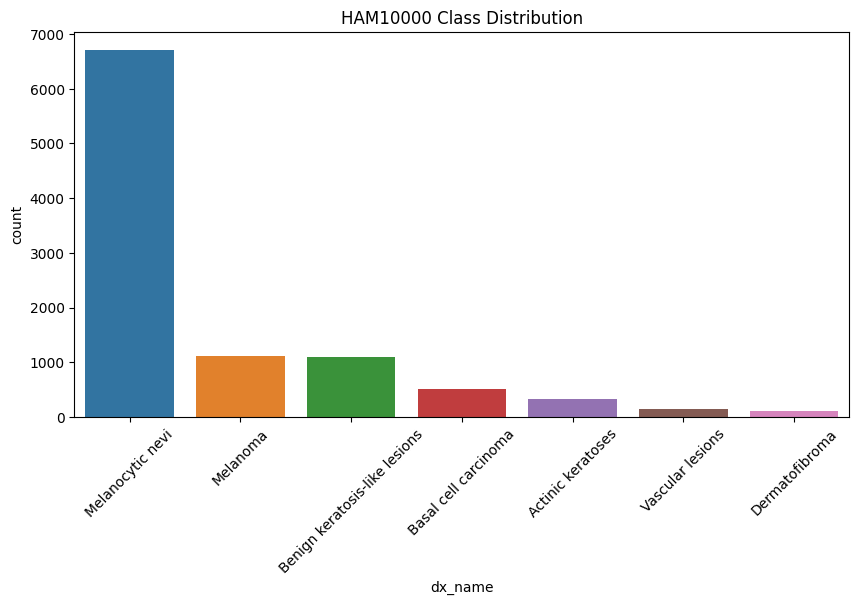

In [10]:
df['dx_name'] = df['dx'].map(class_names)

# Plot class distribution
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='dx_name', order=df['dx_name'].value_counts().index)
plt.xticks(rotation=45)
plt.title('HAM10000 Class Distribution')
plt.show()

In [11]:
# 7) Prepare GroupKFold splits by lesion_id (stratified by dx)
gkf = GroupKFold(n_splits=5)

df['fold'] = -1
X = df.index.values
y = df['dx'].values
groups = df['lesion_id'].values

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    df.loc[val_idx, 'fold'] = fold

print("\nFold distribution:")
print(df['fold'].value_counts())


Fold distribution:
fold
0    2003
2    2003
1    2003
3    2003
4    2003
Name: count, dtype: int64


In [12]:
OUTPUT_PATH = '/kaggle/working/ham10000_metadata_folds.csv'
df.to_csv(OUTPUT_PATH, index=False)
print(f"Saved fold assignments to {OUTPUT_PATH}")


Saved fold assignments to /kaggle/working/ham10000_metadata_folds.csv


In [13]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import numpy as np

In [14]:
 
# Paths
DATA_DIR = '/kaggle/input/skin-cancer-mnist-ham10000'
IMG_DIR1 = os.path.join(DATA_DIR, 'HAM10000_images_part_1')
IMG_DIR2 = os.path.join(DATA_DIR, 'HAM10000_images_part_2')

# If folds file is generated in THIS notebook
METADATA_CSV2 = '/kaggle/working/ham10000_metadata_folds.csv'

# If folds file already exists in dataset uploaded to Kaggle
# METADATA_CSV2 = os.path.join(DATA_DIR, 'ham10000_metadata_folds.csv')




In [15]:
# Load CSV with folds (generated in Phase 1)
df = pd.read_csv(METADATA_CSV2)

In [16]:
# Map classes to indices
class_names = sorted(df['dx'].unique())
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

print("Class to index mapping:", class_to_idx)

Class to index mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [17]:
df.head(1)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_name,fold
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,0


In [18]:
# ---------------------------
# Image Transforms
# ---------------------------
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [19]:
# ---------------------------
# Dataset Class
# ---------------------------
class HAM10000Dataset(Dataset):
    def __init__(self, dataframe, img_dir1, img_dir2, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir1 = img_dir1
        self.img_dir2 = img_dir2
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_filename = row['image_id'] + '.jpg'

        img_path1 = os.path.join(self.img_dir1, img_filename)
        img_path2 = os.path.join(self.img_dir2, img_filename)

        if os.path.exists(img_path1):
            img_path = img_path1
        elif os.path.exists(img_path2):
            img_path = img_path2
        else:
            raise FileNotFoundError(f"Image {img_filename} not found in either folder.")

        image = Image.open(img_path).convert("RGB")
        label = class_to_idx[row['dx']]

        if self.transform:
            image = self.transform(image)

        return image, label

In [20]:
# ---------------------------
# Create DataLoaders
# ---------------------------
# CHANGE: replace your get_dataloaders() with this deterministic version
def get_dataloaders(fold, batch_size=32, use_sampler=False, num_workers=2, seed=42):
    train_df = df[df['fold'] != fold].reset_index(drop=True)
    val_df   = df[df['fold'] == fold].reset_index(drop=True)

    train_dataset = HAM10000Dataset(train_df, IMG_DIR1, IMG_DIR2, transform=train_transforms)
    val_dataset   = HAM10000Dataset(val_df,   IMG_DIR1, IMG_DIR2, transform=val_transforms)

    # deterministic workers
    g = torch.Generator(); g.manual_seed(seed)
    def worker_init_fn(worker_id):
        np.random.seed(seed + worker_id); random.seed(seed + worker_id)

    sampler = None
    if use_sampler:
        # If you ever want it for supervised-only training, not KD:
        class_counts = train_df['dx'].value_counts().to_dict()
        class_weights = {cls: 1.0 / max(1, cnt) for cls, cnt in class_counts.items()}
        sample_weights = [class_weights[row['dx']] for _, row in train_df.iterrows()]
        sampler = WeightedRandomSampler(weights=sample_weights,
                                        num_samples=len(sample_weights),
                                        replacement=True)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=(sampler is None),   # shuffle only if no sampler
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,              # keeps epoch size stable
        persistent_workers=(num_workers > 0),
        generator=g,
        worker_init_fn=worker_init_fn,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False,
        persistent_workers=(num_workers > 0),
        generator=g,
        worker_init_fn=worker_init_fn,
    )
    return train_loader, val_loader


In [22]:
import random


In [23]:
# ---------------------------
# Example: Load fold 0
# ---------------------------
train_loader, val_loader = get_dataloaders(fold=0, batch_size=32, use_sampler=False, num_workers=2, seed=42)

# Check one batch
images, labels = next(iter(train_loader))
print("Batch images shape:", images.shape)
print("Batch labels:", labels)

# (optional) sanity: this should print RandomSampler, not WeightedRandomSampler
print("Train sampler:", type(train_loader.sampler).__name__)

Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([5, 5, 5, 2, 1, 5, 2, 4, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5,
        5, 5, 5, 4, 5, 5, 4, 5])
Train sampler: RandomSampler


# KD 1

# KD2

In [32]:
# ============================
# Simple & Strong KD (EffNet-B4 -> Tiny Student)
# Clean CE + Clean KD with confidence masking
# Needs: train_loader, val_loader, class_to_idx
# ============================

import os, copy, numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report


In [33]:
# ----------------------------
# Paths (your files)
# ----------------------------
TEACHER_CKPT = "/kaggle/input/teacher1.1/pytorch/default/1/teacher_model_best.pth"
SUPERVISED_STUDENT_CKPT = "/kaggle/input/student1/pytorch/default/1/student_supervised_best2.pth"
KD_CKPT = "/kaggle/working/student_kd_best.pth"   # writeable


In [34]:
# ----------------------------
# Config
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(class_to_idx)

WIDTH_MULT = 1.50         # ~149k params; set 1.60 (~177k) if you want a bit more capacity
EPOCHS = 60
LR = 5e-4
WEIGHT_DECAY = 1e-4
LABEL_SMOOTH = 0.0
ALPHA = 0.90              # CE weight (hard labels)
TEMP = 2.0                # KD temperature (sharper for 7 classes)
HEAD_DROPOUT = 0.15
EARLY_STOP_PATIENCE = 15
CONF_THR = 0.65           # teacher confidence threshold for KD
ALLOW_HEAD_MISMATCH = False

print(f"Device: {device} | Classes: {num_classes}")


Device: cuda | Classes: 7


In [35]:
# ----------------------------
# Student model (tiny DS-CNN)
# ----------------------------
class DSBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1, pdrop=0.05):
        super().__init__()
        self.dw = nn.Conv2d(in_c, in_c, 3, stride, 1, groups=in_c, bias=False)
        self.pw = nn.Conv2d(in_c, out_c, 1, 1, 0, bias=False)
        self.bn = nn.BatchNorm2d(out_c)
        self.act = nn.SiLU(inplace=True)
        self.drop = nn.Dropout2d(pdrop) if pdrop > 0 else nn.Identity()
        self.use_res = (stride == 1 and in_c == out_c)
    def forward(self, x):
        y = self.dw(x); y = self.pw(y); y = self.bn(y); y = self.act(y); y = self.drop(y)
        return y + x if self.use_res else y

class StudentNet(nn.Module):
    def __init__(self, num_classes, width_mult=1.0, head_dropout=0.15):
        super().__init__()
        base = [32, 48, 64, 96, 128, 160]
        ch = [max(8, int(c * width_mult)) for c in base]
        self.stem = nn.Sequential(
            nn.Conv2d(3, ch[0], 3, 2, 1, bias=False), nn.BatchNorm2d(ch[0]), nn.SiLU(inplace=True)
        )
        self.stage = nn.Sequential(
            DSBlock(ch[0], ch[0], 1),
            DSBlock(ch[0], ch[1], 2),
            DSBlock(ch[1], ch[1], 1),
            DSBlock(ch[1], ch[2], 2),
            DSBlock(ch[2], ch[2], 1),
            DSBlock(ch[2], ch[3], 2),
            DSBlock(ch[3], ch[3], 1),
            DSBlock(ch[3], ch[4], 1),
            DSBlock(ch[4], ch[5], 1),
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(nn.Dropout(p=head_dropout), nn.Linear(ch[5], num_classes))
    def forward(self, x):
        x = self.stem(x); x = self.stage(x); x = self.pool(x).flatten(1)
        return self.head(x)

def count_params(m): 
    return sum(p.numel() for p in m.parameters() if p.requires_grad)


In [36]:
# ----------------------------
# Robust teacher loader (torchvision EfficientNet-B4)
# ----------------------------
def _unwrap_sd(sd):
    if isinstance(sd, dict) and "state_dict" in sd: sd = sd["state_dict"]
    if isinstance(sd, dict) and "model_state_dict" in sd: sd = sd["model_state_dict"]
    if isinstance(sd, dict) and any(k.startswith("module.") for k in sd.keys()):
        sd = {k.replace("module.", "", 1): v for k, v in sd.items()}
    return sd

def load_teacher_efficientnet_b4(num_classes, ckpt_path, device, allow_head_mismatch=False):
    assert os.path.exists(ckpt_path), f"Teacher checkpoint not found: {ckpt_path}"
    teacher = models.efficientnet_b4(weights=None)
    in_features = teacher.classifier[1].in_features
    teacher.classifier[1] = nn.Linear(in_features, num_classes)

    sd = _unwrap_sd(torch.load(ckpt_path, map_location=device))
    if "classifier.1.weight" in sd:
        saved_out = sd["classifier.1.weight"].shape[0]
        print(f"Teacher head in ckpt: out_dim={saved_out} | current num_classes={num_classes}")
        if saved_out != num_classes and not allow_head_mismatch:
            raise ValueError("Teacher head out_dim != num_classes. Use matching class_to_idx.")

    try:
        teacher.load_state_dict(sd, strict=True)
        print("Loaded teacher (STRICT).")
    except RuntimeError as e:
        print("Strict load failed; falling back to partial.\n", e)
        cur = teacher.state_dict()
        matched = 0
        for k, v in sd.items():
            if k in cur and cur[k].shape == v.shape:
                cur[k] = v; matched += 1
        teacher.load_state_dict(cur, strict=False)
        print(f"Partially loaded teacher. Matched tensors: {matched}/{len(cur)}")

    teacher = teacher.to(device).eval()
    for p in teacher.parameters(): p.requires_grad = False
    return teacher


In [37]:
# ----------------------------
# Class weights (softened inverse-frequency)
# ----------------------------
@torch.no_grad()
def compute_soft_class_weights_from_loader(loader, num_classes, power=0.5):
    counts = np.zeros(num_classes, dtype=np.int64)
    for _, y in loader:
        y = y.cpu().numpy()
        counts += np.bincount(y, minlength=num_classes)
    counts = np.maximum(counts, 1)
    inv = (counts.sum() / (num_classes * counts))
    soft = inv ** power
    w = torch.tensor(soft, dtype=torch.float32, device=device)
    return w / w.mean()

# ----------------------------
# Build teacher & student
# ----------------------------
teacher = load_teacher_efficientnet_b4(
    num_classes=num_classes,
    ckpt_path=TEACHER_CKPT,
    device=device,
    allow_head_mismatch=ALLOW_HEAD_MISMATCH
)

student = StudentNet(num_classes, width_mult=WIDTH_MULT, head_dropout=HEAD_DROPOUT).to(device)
print(f"Student params (trainable): {count_params(student):,}")

# Optional warm-start from supervised baseline (same WIDTH_MULT/arch)
if os.path.exists(SUPERVISED_STUDENT_CKPT):
    try:
        sd = torch.load(SUPERVISED_STUDENT_CKPT, map_location=device)
        student.load_state_dict(sd, strict=True)
        print(f"Warm-started student from: {SUPERVISED_STUDENT_CKPT}")
    except RuntimeError as e:
        print("Warm-start failed (arch mismatch).u Details:\n", e)


Teacher head in ckpt: out_dim=7 | current num_classes=7
Loaded teacher (STRICT).
Student params (trainable): 148,855
Warm-started student from: /kaggle/input/student1/pytorch/default/1/student_supervised_best2.pth


In [38]:
# ----------------------------
# Losses / Optimizer / Scheduler
# ----------------------------


#class_weights = compute_soft_class_weights_from_loader(train_loader, num_classes, power=0.5)
#ce = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=LABEL_SMOOTH)

# CHANGE: use unweighted CE for KD
ce = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)  # LABEL_SMOOTH=0.0 already

kld = nn.KLDivLoss(reduction="batchmean")

optimizer = optim.AdamW(student.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_macro_f1, best_wts, no_improve = -1.0, copy.deepcopy(student.state_dict()), 0

#new 12.27am
# KD coverage accumulators (per-epoch)
kd_cov_sum, kd_cov_cnt = 0.0, 0



*Train Loop*

In [39]:
# 1) Are you accidentally using a sampler?
print("Train sampler:", type(train_loader.sampler).__name__)  # should be 'RandomSampler' for KD

# 2) Quick teacher strength on THIS val split
def eval_macro_f1(model, name):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds.append(model(xb).argmax(1).cpu()); trues.append(yb.cpu())
    import numpy as np
    from sklearn.metrics import f1_score
    p = torch.cat(preds).numpy(); t = torch.cat(trues).numpy()
    print(f"{name} macro-F1:", f1_score(t, p, average="macro")*100.0)

# Build teacher/student as in your script, then:
eval_macro_f1(teacher, "Teacher@val")
eval_macro_f1(student, "WarmStart Student@val")

# ----------------------------
# KD training loop (Clean CE + Clean KD with confidence masking)
# ----------------------------
for epoch in range(1, EPOCHS + 1):
    student.train()
    train_correct = train_total = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        # Teacher + student logits on CLEAN images
        with torch.no_grad():
            t_logits = teacher(xb)
        s_logits = student(xb)

        # Hard CE
        hard_loss = ce(s_logits, yb)

        # KD only on confident samples
        T = TEMP
        t_prob = torch.softmax(t_logits / T, dim=1)
        t_conf, _ = t_prob.max(dim=1)
        mask = t_conf > CONF_THR

        #new 12.30am
        # accumulate KD coverage 
        kd_cov_sum += mask.float().mean().item()
        kd_cov_cnt += 1


        if mask.any():
            s_logp = torch.log_softmax(s_logits[mask] / T, dim=1)
            soft_loss = kld(s_logp, t_prob[mask]) * (T ** 2)
        else:
            soft_loss = torch.tensor(0.0, device=xb.device)

        loss = ALPHA * hard_loss + (1 - ALPHA) * soft_loss

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(student.parameters(), max_norm=5.0)
        optimizer.step()

        with torch.no_grad():
            pred = s_logits.argmax(1)
            train_correct += (pred == yb).sum().item()
            train_total += yb.size(0)

    scheduler.step()
    train_acc = 100.0 * train_correct / max(1, train_total)

    # ---- Validate ----
    student.eval()
    val_correct = val_total = 0
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = student(xb)
            p = out.argmax(1)
            val_correct += (p == yb).sum().item()
            val_total += yb.size(0)
            preds.append(p.cpu()); trues.append(yb.cpu())

    preds = torch.cat(preds).numpy()
    trues = torch.cat(trues).numpy()
    val_acc = 100.0 * val_correct / max(1, val_total)
    val_bal_acc = balanced_accuracy_score(trues, preds) * 100.0
    val_macro_f1 = f1_score(trues, preds, average="macro") * 100.0

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_acc={train_acc:.2f}% | val_acc={val_acc:.2f}% | "
          f"bal_acc={val_bal_acc:.2f}% | macroF1={val_macro_f1:.2f}%")

    #new 12.32
    # report KD coverage this epoch and reset counters
    if kd_cov_cnt > 0:
        print(f"   KD coverage ~ {100.0 * (kd_cov_sum / kd_cov_cnt):.1f}% of samples")
        kd_cov_sum, kd_cov_cnt = 0.0, 0


    if val_macro_f1 > best_macro_f1:
        best_macro_f1 = val_macro_f1
        best_wts = copy.deepcopy(student.state_dict())
        torch.save(best_wts, KD_CKPT)
        print(f"--> New best macro-F1: {best_macro_f1:.2f}. Saved -> {KD_CKPT}")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= EARLY_STOP_PATIENCE:
            print(" Early stopping triggered.")
            break



Train sampler: RandomSampler
Teacher@val macro-F1: 72.49140494788226
WarmStart Student@val macro-F1: 59.98525488509586
Epoch 01/60 | train_acc=74.62% | val_acc=78.68% | bal_acc=64.82% | macroF1=64.28%
   KD coverage ~ 42.4% of samples
--> New best macro-F1: 64.28. Saved -> /kaggle/working/student_kd_best.pth
Epoch 02/60 | train_acc=78.84% | val_acc=79.08% | bal_acc=64.71% | macroF1=65.76%
   KD coverage ~ 42.1% of samples
--> New best macro-F1: 65.76. Saved -> /kaggle/working/student_kd_best.pth
Epoch 03/60 | train_acc=79.15% | val_acc=79.38% | bal_acc=64.82% | macroF1=65.36%
   KD coverage ~ 42.2% of samples
Epoch 04/60 | train_acc=79.03% | val_acc=79.08% | bal_acc=63.04% | macroF1=63.96%
   KD coverage ~ 42.1% of samples
Epoch 05/60 | train_acc=79.94% | val_acc=78.28% | bal_acc=65.61% | macroF1=63.07%
   KD coverage ~ 42.4% of samples
Epoch 06/60 | train_acc=79.92% | val_acc=78.68% | bal_acc=63.03% | macroF1=64.04%
   KD coverage ~ 42.0% of samples
Epoch 07/60 | train_acc=80.06% | va

In [40]:
# ---- Load best and final report
student.load_state_dict(best_wts)
print(f"KD fully done. Best macro-F1: {best_macro_f1:.2f}")

student.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        p = student(xb).argmax(1)
        all_preds.append(p.cpu()); all_trues.append(yb.cpu())
all_preds = torch.cat(all_preds).numpy()
all_trues = torch.cat(all_trues).numpy()

print("\nClassification Report (KD):\n")
print(classification_report(all_trues, all_preds, digits=2))


KD fully done. Best macro-F1: 67.53

Classification Report (KD):

              precision    recall  f1-score   support

           0       0.40      0.52      0.45        56
           1       0.74      0.58      0.65       108
           2       0.61      0.57      0.59       239
           3       0.75      0.65      0.70        23
           4       0.58      0.47      0.52       226
           5       0.89      0.93      0.91      1319
           6       0.91      0.91      0.91        32

    accuracy                           0.80      2003
   macro avg       0.70      0.66      0.68      2003
weighted avg       0.80      0.80      0.80      2003



In [41]:
# after training, before the final report
student.load_state_dict(torch.load(KD_CKPT, map_location=device))
student.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        out0 = student(xb)
        out1 = student(torch.flip(xb, dims=[-1]))  # hflip
        out = (out0 + out1) / 2.0
        p = out.argmax(1)
        all_preds.append(p.cpu()); all_trues.append(yb.cpu())
all_preds = torch.cat(all_preds).numpy()
all_trues = torch.cat(all_trues).numpy()
from sklearn.metrics import classification_report, f1_score
print("TTA macro-F1:", f1_score(all_trues, all_preds, average="macro")*100)
print("\nTTA Classification Report:\n", classification_report(all_trues, all_preds, digits=2))


TTA macro-F1: 68.42778405445799

TTA Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.52      0.47        56
           1       0.75      0.65      0.70       108
           2       0.63      0.57      0.60       239
           3       0.88      0.61      0.72        23
           4       0.59      0.48      0.53       226
           5       0.88      0.93      0.91      1319
           6       0.90      0.84      0.87        32

    accuracy                           0.81      2003
   macro avg       0.72      0.66      0.68      2003
weighted avg       0.80      0.81      0.80      2003



***Evaluation of Student after Knowledge Distillation***

In [47]:
import numpy as np, torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns

# load best and eval
student.load_state_dict(torch.load(KD_CKPT, map_location=device))
student.eval()

# collect labels

y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        y_true.append(yb.numpy())
        y_pred.append(student(xb).argmax(1).cpu().numpy())
y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)


In [48]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate Macro metrics
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)

# Calculate Weighted metrics
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

# Display results
print(f"Accuracy: {accuracy*100:.2f}%\n")

print("Macro Metrics:")
print(f"  Precision: {macro_precision*100:.2f}%")
print(f"  Recall:    {macro_recall*100:.2f}%")
print(f"  F1-score:  {macro_f1*100:.2f}%\n")

print("Weighted Metrics:")
print(f"  Precision: {weighted_precision*100:.2f}%")
print(f"  Recall:    {weighted_recall*100:.2f}%")
print(f"  F1-score:  {weighted_f1*100:.2f}%\n")


Accuracy: 80.28%

Macro Metrics:
  Precision: 69.62%
  Recall:    66.20%
  F1-score:  67.53%

Weighted Metrics:
  Precision: 79.64%
  Recall:    80.28%
  F1-score:  79.78%



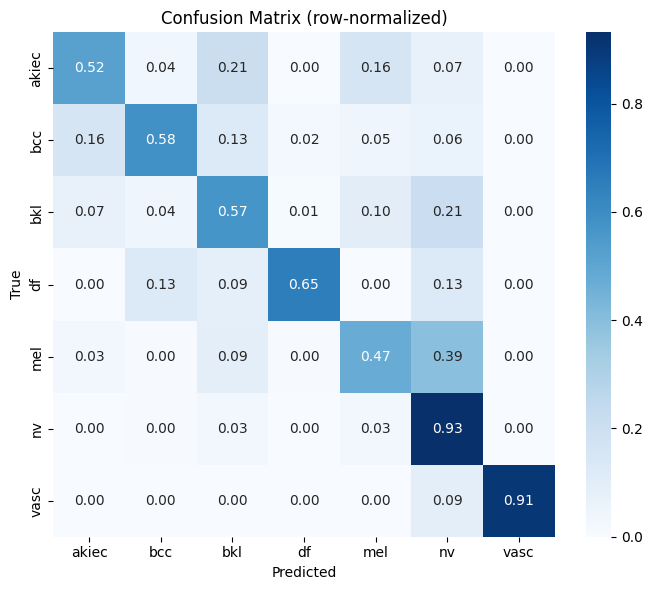

In [49]:
# confusion matrix 

cm = confusion_matrix(y_true, y_pred, labels=range(len(names)), normalize="true")
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=names, yticklabels=names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (row-normalized)")
plt.tight_layout()
plt.savefig("/kaggle/working/confusion_matrix.png", dpi=200)
plt.show()